In [1]:
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from functions import *

from tqdm import tqdm

Using cupy


In [2]:
@dataclass
class Config:
    nx: int = 1675
    ny: int = 670
    steps: int = 1500000
    output_stride: int = 1000
    molecular_weights: tuple[float, float, float] = (1, 1)
    pressure_frac: tuple[float, float, float] = (0.5, 0.5)
    total_pressure: float = 1.0
    theta: float = 0.5
    nB: int = 10

    vx = 0.15

In [3]:
def initialise_chamber(config: Config, absorption_coefficient, ini_slope):
    nx, ny = config.nx, config.ny
    species = 2
    phi = 1.0 / xp.array(config.molecular_weights, dtype=xp.float32)

    # Partial pressures for each species
    psigma = xp.zeros((species, nx, ny), dtype=xp.float32)
    pressure = xp.array(config.pressure_frac, dtype=xp.float32) * config.total_pressure
    for s in range(species):
        psigma[s, :, :] = pressure[s]

    # Convert partial pressures to densities: p_s = phi_s * rho_s / 3
    rho_s = xp.zeros_like(psigma)
    for s in range(species):
        rho_s[s] = 3.0 * psigma[s] / phi[s]

    # Initial populations from equilibrium with zero velocity
    f = xp.zeros((species, 9, nx, ny), dtype=xp.float32)
    ux_s = xp.ones((species, nx, ny), dtype=xp.float32) * config.vx
    uy_s = xp.zeros((species, nx, ny), dtype=xp.float32)
    feq = equilibrium(f, rho_s, phi, ux_s, uy_s)
    f[...] = feq
    return f, phi

In [4]:
def lattice_flow_object(f, phi, step, non_absorb_mask, bc_top, bc_bottom):
    f_streamed = xp.zeros_like(f, dtype=xp.float32)
    for i in range(w.shape[0]): # for each species
        f_streamed[:, i, :, :] = xp.roll(f[:, i, :, :], (int(D2Q9_CX[i]), int(D2Q9_CY[i])),axis=(1, 2))

    nx = f_streamed.shape[2]
    ny = f_streamed.shape[3]
    X, Y = xp.meshgrid(xp.arange(nx), xp.arange(ny))
    R = ny//6
    cylinder = ((X-(nx/5.5))**2 + (Y-(ny/2))**2) < R**2
    cylinder = cylinder.T
    cylinder[:, :1] = True
    cylinder[:, -1:] = True

    inside_boundary = f_streamed[:, :, cylinder]
    inside_boundary = inside_boundary[:, [0,5,6,7,8,1,2,3,4], :] #OPPOSITE
    f_streamed[:, :, cylinder] = inside_boundary

    ux_in = xp.ones(f_streamed.shape[3]) * Config.vx
    uy_in = xp.ones(f_streamed.shape[3]) * 0

    #for s in range(f_streamed.shape[0]):

    C_in_1 = xp.ones(ny) * 3 * 1 / phi[0] * 0.5
    C_in_1[ny//2 - ny//8: ny//2 + ny//5] *= 1.1
    f_in_eq_1 = eq_single_boundary(C_in_1, phi[0], ux_in, uy_in)
    f_streamed[0, :, 0, :] = f_in_eq_1

    C_in_2 = xp.ones(ny) * 3 * 1 / phi[1] * 0.5
    C_in_2[ny//2 - ny//8: ny//2 + ny//5] *= 0.9
    f_in_eq_2 = eq_single_boundary(C_in_2, phi[1], ux_in, uy_in)
    f_streamed[1, :, 0, :] = f_in_eq_2

    f_streamed[:, :, -1, :] = f_streamed[:, :, -2, :]

    return f_streamed

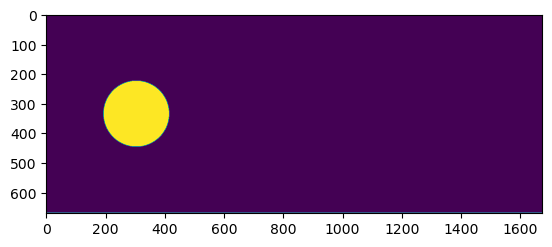

In [5]:
nx = Config.nx
ny = Config.ny
X, Y = np.meshgrid(range(nx), range(ny))

R = ny//6

cylinder = ((X-(nx/5.5))**2 + (Y-(ny/2))**2) < R**2
cylinder = cylinder.T

cylinder[:, :1] = True
cylinder[:, -1:] = True

plt.imshow(cylinder.T)

In [6]:
def main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, ini_slope, Config):
    cfg = Config()
    out_dir = 'demo_frames'

    f, phi = initialise_chamber(cfg, absorption_coefficient, ini_slope)
    molecular_weights = xp.array(cfg.molecular_weights, dtype=xp.float32)

    velocity_field = []
    for step in tqdm(range(cfg.steps + 1)):
        #f_old = xp.copy(f)

        if step % cfg.output_stride == 0:
            save_concentration_frames(f, phi, step, molecular_weights)
            rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)
            plot_vector(to_numpy(ux_s[0]), to_numpy(uy_s[0]), step, zoom = 0.15, skip = 25, shapes=cylinder)
        if step % 500 == 0:
            rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)
            ux_s = to_numpy(ux_s).astype(np.float32)
            uy_s = to_numpy(uy_s).astype(np.float32)
            velocity_field.append((ux_s, uy_s))
            np.save("flow_field", np.array(velocity_field))
        if step == cfg.steps:
            break
        f = bgk_step(f, molecular_weights, phi, cfg.nB, lattice_flow_object, step,
                     non_absorb_mask, bc_top, bc_bottom)

    return f

In [7]:
absorption_coefficient = 100
bc_top = None
bc_bottom = None
non_absorb_mask = None

In [8]:
f= main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, True, Config)

 13%|█▎        | 187839/1500001 [1:38:42<11:29:35, 31.71it/s] 


KeyboardInterrupt: 

In [16]:
velocity_field = np.load("flow_field.npy")
print(velocity_field.shape)
# frames, components, species, nx, ny

specie_id = 0
vx = velocity_field[:, 0, specie_id, :, :]
vy = velocity_field[:, 1, specie_id, :, :]
print(vx.shape)

(31, 2, 2, 1000, 500)
(31, 1000, 500)


In [17]:
vx_avg = np.mean(vx, axis = 0)
vy_avg = np.mean(vy, axis = 0)
plot_vector(vx_avg, vy_avg, 666, zoom = 0.15, skip = 25, shapes=cylinder)

(<Figure size 1050x750 with 2 Axes>,
 <Axes: title={'center': 'Velocity field (color = |u|)'}, xlabel='x', ylabel='y'>)